# Instalacion y carga de librerias

In [29]:
!pip install pycaret
!pip install pyyaml
!pip install markupsafe

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import numpy as np

%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import xgboost as xgb

import jinja2

from google.colab import files
from google.colab import drive

# Carga del archivo

In [31]:
# Cargar el archivo CSV "resultados_incidentes_viales2.csv"
Archivo = files.upload()

Saving registros_autos_entrenamiento - Hoja1.csv to registros_autos_entrenamiento - Hoja1 (1).csv


In [32]:
data = pd.read_csv("registros_autos_entrenamiento - Hoja1.csv",sep=',',on_bad_lines='skip')

# Pre-procesamiento

In [33]:
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')

Se crea una copia para evitar perdida de informacion

In [34]:
data2 = data.copy()

# EDA

In [35]:
data.describe()

,Unidades
count,2192.000000
mean,782.165602
std,551.164725
min,0.000000
25%,293.000000
50%,865.500000
75%,1173.000000
max,3603.000000


Serie de tiempo y su grafica. Se genera ademas una media movil con un rango de 30 dias.

In [36]:
# create 30 days moving average
data2['MA'] = data2.rolling(window=7).mean()# plot the data and MA

fig = px.line(data2, x='Fecha', y=['Unidades', 'MA'])
fig.show()

In [37]:
ts_decomposition = seasonal_decompose(x=data['Unidades'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

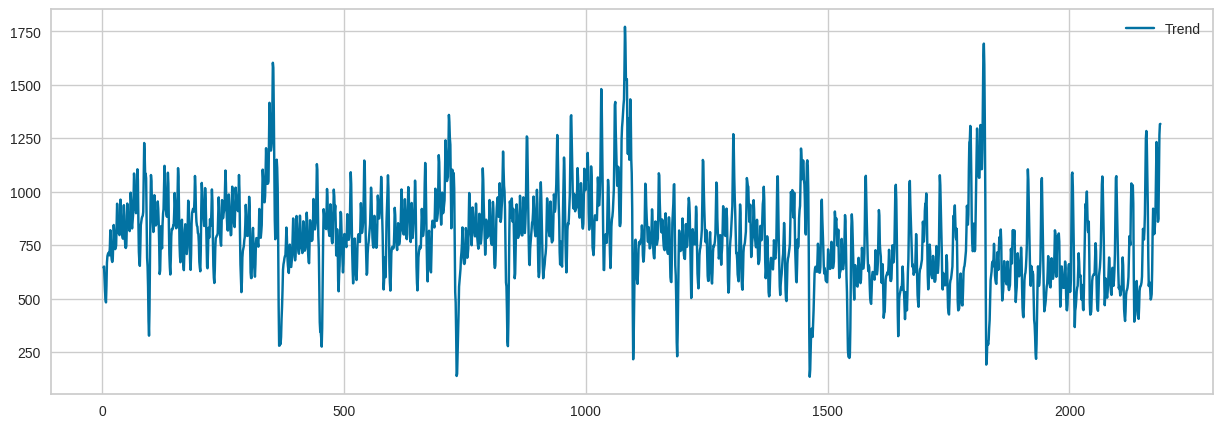

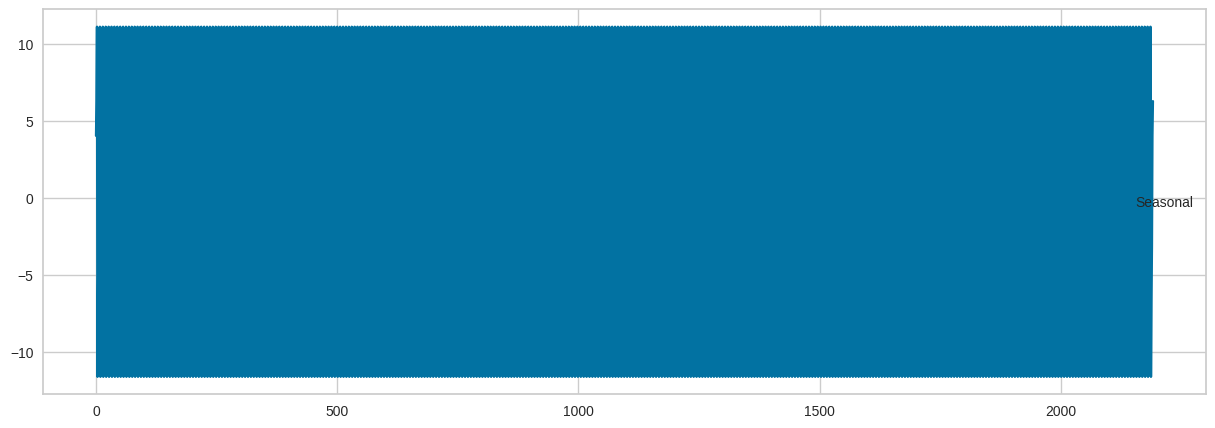

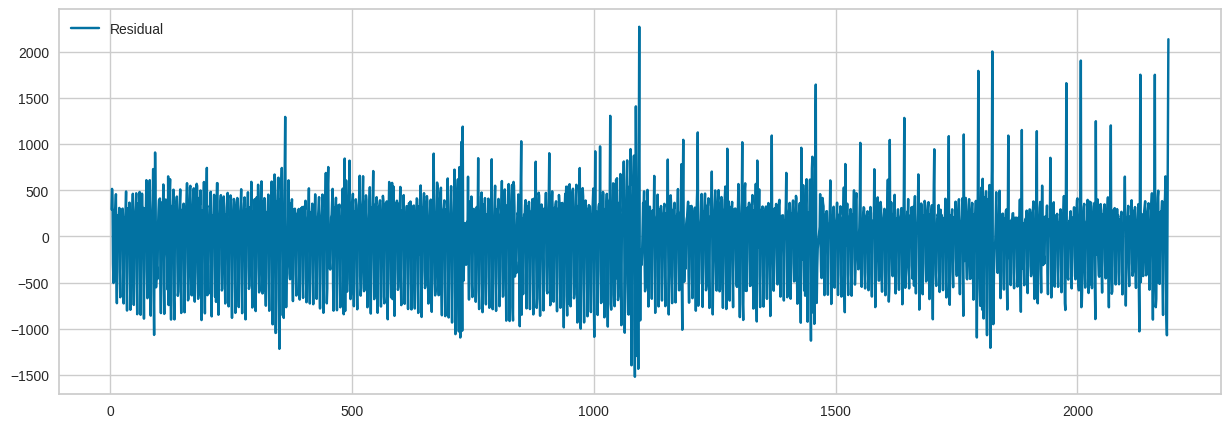

In [38]:
plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [39]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Histogram(x=data['Unidades'], name='Unidades'), row=1, col=1)
fig.add_trace(go.Box(x=data['Unidades'], name='Unidades'), row=1, col=2)

fig.update_layout(height=600, width=1300, title_text='<b>Continuos distributions', title_x=0.5)
fig.show()

# Modelamiento

In [109]:
from pycaret.regression import *# initialize setup

# Modelo 1

Unicamente se usa el mes y el dia, ademas de la posicion de la observacion que se halla como 'serie'

In [41]:
data3 = data.copy()

data3['Año']=data3['Fecha'].dt.year
data3['Mes']=data3['Fecha'].dt.month
data3['Dia']=data3['Fecha'].dt.day

data3 = data3[['Fecha', 'Año', 'Mes', 'Dia', 'Unidades']] # check the head of the dataset

In [42]:
# Dividir los datos en entrenamiento y validación
train_data1 = data3.loc[data3['Año'] < 2017]
test_data1 = data3.loc[data3['Año'] >= 2017]

Configuracion

In [43]:
s1 = setup(data = train_data1, test_data = test_data1, target = 'Unidades', fold_strategy = 'timeseries',
           numeric_features = ['Año','Mes','Dia'], fold = 3, transform_target = True,
           session_id = 123, data_split_shuffle=False, fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,Unidades
2,Target type,Regression
3,Original data shape,"(2192, 5)"
4,Transformed data shape,"(2192, 7)"
5,Transformed train set shape,"(1827, 7)"
6,Transformed test set shape,"(365, 7)"
7,Numeric features,3
8,Date features,1
9,Preprocess,True


In [44]:
best1 = compare_models(sort = 'R2')
best1

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,443.0667,294713.1730,542.5642,0.0366,2.7731,35.0777,0.1567
en,Elastic Net,476.6335,306740.7393,552.6345,0.0017,2.6834,27.8647,0.0667
lasso,Lasso Regression,476.7337,306989.3847,552.8514,0.0010,2.6836,27.8733,0.1033
llar,Lasso Least Angle Regression,476.7337,306989.3847,552.8514,0.0010,2.6836,27.8733,0.1167
br,Bayesian Ridge,479.0053,309979.1839,555.4861,-0.0088,2.6817,27.6656,0.1367
omp,Orthogonal Matching Pursuit,481.1252,314279.0878,559.3662,-0.0224,2.6791,27.5100,0.0967
ridge,Ridge Regression,489.1992,321975.6545,565.9860,-0.0508,2.6632,25.7987,0.0933
lar,Least Angle Regression,489.2985,322126.2394,566.1147,-0.0513,2.6630,25.7832,0.0633
lr,Linear Regression,489.2985,322126.2394,566.1147,-0.0513,2.6630,25.7832,2.4267
dummy,Dummy Regressor,487.8964,328784.8167,572.3151,-0.0698,2.6864,27.6260,0.1167


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

HuberRegressor()

In [45]:
tuned_model1 = tune_model(best1, optimize="R2")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,465.7330,278552.2149,527.7805,0.0218,2.7317,38.8342
1,487.2663,327135.3295,571.9575,0.0585,2.6720,41.4617
2,395.8024,266866.1821,516.5909,0.0721,2.8223,17.3827
Mean,449.6006,290851.2422,538.7763,0.0508,2.7420,32.5595
Std,39.0436,26096.5143,23.9032,0.0213,0.0618,10.7851


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [46]:
# generate predictions on the original dataset
predictions1train = predict_model(tuned_model1, data=train_data1)# add a date column in the dataset

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,463.7456,292144.3249,540.5038,0.0413,2.7089,32.7402


In [47]:
# generate predictions on the original dataset
predictions1test = predict_model(tuned_model1, data=test_data1)# add a date column in the dataset

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,373.1962,254264.8209,504.2468,0.0893,2.8494,27.2349


In [48]:
predictions1 = predict_model(tuned_model1, data=data3)# add a date column in the dataset
predictions1

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,448.6678,285836.8345,534.6371,0.0586,2.7328,31.8456


,Fecha,Año,Mes,Dia,Unidades,prediction_label
0,2012-01-01,2012,1,1,0,470.611563
1,2012-01-02,2012,1,2,188,481.283936
2,2012-01-03,2012,1,3,482,492.073342
3,2012-01-04,2012,1,4,927,502.979730
4,2012-01-05,2012,1,5,1159,514.003051
...,...,...,...,...,...,...
2187,2017-12-27,2017,12,27,2102,1013.952850
2188,2017-12-28,2017,12,28,3449,1029.464078
2189,2017-12-29,2017,12,29,1084,1045.090605
2190,2017-12-30,2017,12,30,18,1060.832396


In [49]:
fig = px.line(predictions1, x='Fecha', y=['Unidades','prediction_label'],width=1600, height=600)# add a vertical rectange for test-set separation
fig.add_vrect(x0='2017–01–01', x1='2017–12–31', fillcolor='grey', opacity=0.25, line_width=0)
fig.show()

In [50]:
evaluate_model(tuned_model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Modelo 2

Se incluyen las variables dia de la semana, dia del mes, trimestre y un indicador si es quincena lo cual le permite en las estimaciones de los posibles modelos hallar un patron diariio, semanal, trimestral y anual.

In [51]:
data4 = data.copy()

data4['Año']=data4['Fecha'].dt.year
data4['Mes']=data4['Fecha'].dt.month
data4['Dia']=data4['Fecha'].dt.day
data4["Trimestre"]=data4["Fecha"].dt.quarter
data4['Dia_semana'] = data4['Fecha'].dt.dayofweek
data4['Dia_año'] = data4['Fecha'].dt.dayofyear
# Crear la columna "DIA_QUINCENA" con valor 1 si es día de quincena, 0 de lo contrario
data4['Quincena'] = 0  # Inicialmente, todos los días no son de quincena
data4.loc[data4['Fecha'].dt.day.isin([15, 30, 31]), 'Quincena'] = 1


In [52]:
data4

,Fecha,Unidades,Año,Mes,Dia,Trimestre,Dia_semana,Dia_año,Quincena
0,2012-01-01,0,2012,1,1,1,6,1,0
1,2012-01-02,188,2012,1,2,1,0,2,0
2,2012-01-03,482,2012,1,3,1,1,3,0
3,2012-01-04,927,2012,1,4,1,2,4,0
4,2012-01-05,1159,2012,1,5,1,3,5,0
...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,2017,12,27,4,2,361,0
2188,2017-12-28,3449,2017,12,28,4,3,362,0
2189,2017-12-29,1084,2017,12,29,4,4,363,0
2190,2017-12-30,18,2017,12,30,4,5,364,1


In [53]:
# Dividir los datos en entrenamiento y validación
train_data2 = data4.loc[data4['Año'] < 2017]
test_data2 = data4.loc[data4['Año'] >= 2017]

In [54]:
s2 = setup(data = train_data2, test_data = test_data2, target = 'Unidades',
           fold_strategy = 'timeseries', numeric_features = ['Año','Mes','Dia',"Trimestre",'Dia_semana','Dia_año','Quincena'],
           fold = 3, transform_target = True, session_id = 123, data_split_shuffle=False,
           fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,Unidades
2,Target type,Regression
3,Original data shape,"(2192, 9)"
4,Transformed data shape,"(2192, 11)"
5,Transformed train set shape,"(1827, 11)"
6,Transformed test set shape,"(365, 11)"
7,Numeric features,7
8,Date features,1
9,Preprocess,True


In [55]:
best2 = compare_models(sort = 'R2')
best2

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,195.9229,93031.3493,304.8467,0.6948,1.3975,2.1158,0.7000
gbr,Gradient Boosting Regressor,198.2565,97431.8406,307.7261,0.6868,1.4188,1.6579,0.1733
xgboost,Extreme Gradient Boosting,206.0282,109477.1464,329.1334,0.6461,1.3674,1.8779,0.1267
dt,Decision Tree Regressor,206.1762,115654.8984,339.9019,0.6218,1.5658,2.4150,0.0667
rf,Random Forest Regressor,219.7896,115709.8795,336.9014,0.6158,1.3454,2.0343,0.4667
et,Extra Trees Regressor,223.9947,135295.6206,365.6433,0.5515,1.3898,2.1392,0.3200
ada,AdaBoost Regressor,314.8970,175317.9524,415.7902,0.4355,1.4933,1.9876,0.1000
en,Elastic Net,403.1909,260480.6940,509.4293,0.1517,2.4730,13.9984,0.0733
llar,Lasso Least Angle Regression,404.1357,263447.6482,512.1497,0.1424,2.4907,13.9671,0.1267
lasso,Lasso Regression,404.1532,267303.4833,516.1861,0.1290,2.4468,12.8332,0.0633


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

LGBMRegressor(n_jobs=-1, random_state=123)

In [56]:
tuned_model2 = tune_model(best2, optimize="R2")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,207.6599,93108.4771,305.1368,0.6730,1.4110,1.9327
1,198.3517,93127.2391,305.1676,0.7320,1.5118,3.0628
2,187.7628,80261.8085,283.3052,0.7209,1.5861,1.8412
Mean,197.9248,88832.5082,297.8698,0.7087,1.5030,2.2789
Std,8.1285,6060.4047,10.2988,0.0256,0.0718,0.5556


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [57]:
predictions2train = predict_model(tuned_model2, data=train_data2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,130.9885,43026.3514,207.4279,0.8588,1.4002,2.4877


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


In [58]:
predictions2test = predict_model(tuned_model2, data=test_data2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,147.4652,63463.8683,251.9204,0.7727,1.5000,3.5281


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


In [59]:
predictions2 = predict_model(tuned_model2, data=data4)# add a date column in the dataset
predictions2

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,133.7321,46429.4964,215.4750,0.8471,1.4173,2.6568


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


,Fecha,Año,Mes,Dia,Trimestre,Dia_semana,Dia_año,Quincena,Unidades,prediction_label
0,2012-01-01,2012,1,1,1,6,1,0,0,-6.790243
1,2012-01-02,2012,1,2,1,0,2,0,188,220.650762
2,2012-01-03,2012,1,3,1,1,3,0,482,478.973931
3,2012-01-04,2012,1,4,1,2,4,0,927,703.190983
4,2012-01-05,2012,1,5,1,3,5,0,1159,726.311658
...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2017,12,27,4,2,361,0,2102,1532.443762
2188,2017-12-28,2017,12,28,4,3,362,0,3449,1687.773856
2189,2017-12-29,2017,12,29,4,4,363,0,1084,1789.654877
2190,2017-12-30,2017,12,30,4,5,364,1,18,563.977787


In [60]:
fig = px.line(predictions2, x='Fecha', y=['Unidades','prediction_label'],width=1600, height=600)# add a vertical rectange for test-set separation
fig.add_vrect(x0='2017–01–01', x1='2017–12–31', fillcolor='grey', opacity=0.25, line_width=0)
fig.show()

In [61]:
fig = px.line(predictions2test, x='Fecha', y=['Unidades','prediction_label'],width=1600, height=600)# add a vertical rectange for test-set separation
fig.add_vrect(x0='2017–01–01', x1='2017–12–31', fillcolor='grey', opacity=0.25, line_width=0)
fig.show()

In [62]:
evaluate_model(tuned_model2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Modelo 3

In [63]:
from pycaret.time_series import *

In [64]:
data5 = data.copy()
data5.set_index('Fecha', drop=True,inplace=True )

In [66]:
s3 = setup(data5, fold=3, fh=365, session_id=123)

,Description,Value
0,session_id,123
1,Target,Unidades
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(2192, 1)"
5,Transformed data shape,"(2192, 1)"
6,Transformed train set shape,"(1827, 1)"
7,Transformed test set shape,"(365, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [67]:
#check_stats()

In [73]:
best3 = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.0629,0.9402,250.9932,374.6196,175571800259522048.0000,0.5712,0.5365,14.0533
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.0687,0.9478,252.4085,377.7074,176883204039858592.0000,0.5727,0.5285,12.3967
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.0688,0.9478,252.4237,377.7423,176951285360689376.0000,0.5726,0.5284,11.0067
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.0688,0.9478,252.4240,377.7429,176951494561921152.0000,0.5726,0.5284,14.9133
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.0688,0.9478,252.4238,377.7426,176951378058849792.0000,0.5726,0.5284,16.0133
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.0688,0.9478,252.4240,377.7429,176951494534502080.0000,0.5726,0.5284,10.5067
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.0688,0.9478,252.4237,377.7424,176951284523204608.0000,0.5726,0.5284,11.1400
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0859,0.9853,256.8773,393.6735,184021711120206112.0000,0.5907,0.4803,12.1533
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.1058,0.9545,255.1819,377.5666,183874363091014944.0000,0.6108,0.5373,15.4433
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.1374,0.9670,269.1583,385.7025,201157059495770208.0000,0.5903,0.5059,18.3467


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

In [86]:
tuned_model3 = tune_model(best3, optimize="R2")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,1.0972,1.0305,230.0599,378.6951,158155101786887136.0000,0.5252,0.6190
1,2015-01-01,1.0437,0.8838,254.9860,361.7178,223904427955567776.0000,0.5739,0.5258
2,2016-01-01,1.0479,0.9062,267.9337,383.4459,144655871036111200.0000,0.6146,0.4647
Mean,NaT,1.0629,0.9402,250.9932,374.6196,175571800259522048.0000,0.5712,0.5365
SD,NaT,0.0243,0.0645,15.7176,9.3268,34617813167203380.0000,0.0366,0.0634


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.9min finished


In [89]:
predictions3 = predict_model(tuned_model3)# add a date column in the dataset
predictions3

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,OrthogonalMatchingPursuit,0.9895,0.9042,256.8242,390.0613,161812187689955744.0000,0.6417,0.4550


,y_pred
2017-01-01,-160.0096
2017-01-02,592.2056
2017-01-03,957.3110
2017-01-04,1105.2631
2017-01-05,1116.1095
...,...
2017-12-27,1091.1252
2017-12-28,1097.3846
2017-12-29,1142.1867
2017-12-30,282.7377


In [104]:
dfi = predictions3.reset_index()
dfi.columns = ['Fecha', 'y_pred']
dfi['Fecha'] = pd.to_timestamp(dfi['Fecha'], format='%Y/%m/%d')
dfi = dfi.to_da

AttributeError: ignored

In [100]:
dfi

,Fecha,y_pred
0,2017-01-01,-160.0096
1,2017-01-02,592.2056
2,2017-01-03,957.3110
3,2017-01-04,1105.2631
4,2017-01-05,1116.1095
...,...,...
360,2017-12-27,1091.1252
361,2017-12-28,1097.3846
362,2017-12-29,1142.1867
363,2017-12-30,282.7377


In [102]:
fig = px.line(dfi, x='Fecha',y='y_pred' ,width=1600, height=600)
fig.show()

TypeError: ignored

In [ ]:
evaluate_model(final_tuned_model3)

# **Predicciones 2018**

Una vez escogido el mejor modelo se procede a predecir el año 2018

In [105]:
Fechas2018 = pd.date_range(start = '2018-01-01',end = '2018-12-31')
Fechas2018df = pd.DataFrame()
Fechas2018df['Fecha'] = Fechas2018

In [106]:
Fechas2018df['Año']=Fechas2018df['Fecha'].dt.year
Fechas2018df['Mes']=Fechas2018df['Fecha'].dt.month
Fechas2018df['Dia']=Fechas2018df['Fecha'].dt.day
Fechas2018df["Trimestre"]=Fechas2018df["Fecha"].dt.quarter
Fechas2018df['Dia_semana'] = Fechas2018df['Fecha'].dt.dayofweek
Fechas2018df['Dia_año'] = Fechas2018df['Fecha'].dt.dayofyear
# Crear la columna "DIA_QUINCENA" con valor 1 si es día de quincena, 0 de lo contrario
Fechas2018df['Quincena'] = 0  # Inicialmente, todos los días no son de quincena
Fechas2018df.loc[Fechas2018df['Fecha'].dt.day.isin([15, 30, 31]), 'Quincena'] = 1

In [107]:
Fechas2018df

,Fecha,Año,Mes,Dia,Trimestre,Dia_semana,Dia_año,Quincena
0,2018-01-01,2018,1,1,1,0,1,0
1,2018-01-02,2018,1,2,1,1,2,0
2,2018-01-03,2018,1,3,1,2,3,0
3,2018-01-04,2018,1,4,1,3,4,0
4,2018-01-05,2018,1,5,1,4,5,0
...,...,...,...,...,...,...,...,...
360,2018-12-27,2018,12,27,4,3,361,0
361,2018-12-28,2018,12,28,4,4,362,0
362,2018-12-29,2018,12,29,4,5,363,0
363,2018-12-30,2018,12,30,4,6,364,1


In [110]:
predictions2018 = predict_model(tuned_model2, data=Fechas2018df)# add a date column in the dataset
predictions2018

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


,Fecha,Año,Mes,Dia,Trimestre,Dia_semana,Dia_año,Quincena,prediction_label
0,2018-01-01,2018,1,1,1,0,1,0,85.207417
1,2018-01-02,2018,1,2,1,1,2,0,176.461353
2,2018-01-03,2018,1,3,1,2,3,0,318.902594
3,2018-01-04,2018,1,4,1,3,4,0,430.980706
4,2018-01-05,2018,1,5,1,4,5,0,508.285725
...,...,...,...,...,...,...,...,...,...
360,2018-12-27,2018,12,27,4,3,361,0,1437.886074
361,2018-12-28,2018,12,28,4,4,362,0,1659.054974
362,2018-12-29,2018,12,29,4,5,363,0,685.306870
363,2018-12-30,2018,12,30,4,6,364,1,32.214583


In [112]:
predictions2018_A = predictions2018[['Fecha', 'prediction_label']]

In [115]:
drive.mount('/drive')

Mounted at /drive


In [116]:
predictions2018_A.to_csv('/drive/My Drive/Equipo 7 - Fundamentos de analitica/Trabajo4_Autos_Matriculados/predictions2018_A.csv')


In [118]:
predictions2012_2016 = predictions2train[['Fecha','Unidades','prediction_label']]

In [120]:
predictions2012_2016.to_csv('/drive/My Drive/Equipo 7 - Fundamentos de analitica/Trabajo4_Autos_Matriculados/predictions2012_2016.csv')


In [121]:
predictions2017 = predictions2test[['Fecha','Unidades','prediction_label']]

In [122]:
predictions2017.to_csv('/drive/My Drive/Equipo 7 - Fundamentos de analitica/Trabajo4_Autos_Matriculados/predictions2017.csv')
